# カーネル主成分分析を使った非線型写像

機械学習の多くのアルゴリズムはデータの線形分離性を前提としているが、現実の問題では非線形問題に遭遇するほうがはるかに多い<br>
カーネルPCAは線形に分離できないデータを変換し、線形分離器に適した新しい低次元空間に射影する方法である<br>
サンプル${\bf x} \in \mathbb R^d$を高次元のk次元空間に射影する関数$\phi$は以下<br>

$$
\phi : \mathbb R^d \to \mathbb R^k (k >> d)
$$

2->3次元に変換する例

$$
x = \left[ x_1, x_2 \right]^T
$$
$$
\downarrow \phi
$$
$$
z = \left[ x_1^2, \sqrt{2x_1x_2}, x_2^2 \right]^T
$$

こうして高次元に変換したデータにPCAを適用し、より低次元のデータに射影、サンプルを分離できるようにする<br>
ただし、このような計算は非常にコストが高いため、カーネルトリックを用い、計算量を減らす

カーネルトリックに用いられるカーネル関数には以下のようなものがある<br>

* 多項式カーネル
* 双曲線正接（S字）カーネル
* 動径基底関数（RBF)カーネル

以下の例でRBFカーネルを用いる。処理の流れは以下の通り。<br>

1. カーネル（類似度）行列 $k({\bf x^{(i)}}, {\bf x^{(j)}}) = exp\left( -\gamma\|{\bf x^{(i)}} - {\bf x^{(j)}}\|\right)$をすべてのサンプルの組み合わせで行う（サンプルが100なら100×100次元）
2. 以下の式でカーネルの中心化を行う
$$
\bf K' = K - 1_n K - K 1_n + 1_n K 1_n
$$
ここで、$1_n$はすべての値が$\frac{1}{n}$のn×nの行列
3. 上記のK'の固有値に対応するk個の固有ベクトルを収集する。PCAの場合と異なり、これは主成分軸ではなく射影されたサンプルである。
   "類似度"行列を用いていることから、新しいサンプルは、「それぞれのデータとの距離」を特徴量として抽出したものになっている。
   
本来であれば計算の過程で、高次元空間への射影のための$\phi(x)$を計算し、それをPCAに適用する必要があるが、<br>
いろいろ式を変形していくと（カーネルトリック）、カーネル関数の計算で途中を飛ばして射影されたサンプルを得られる<br>
ただし、上記のステップだけでは処理に用いたデータしか射影できず、追加のサンプルは変換できない。解決法は後述<br>
以下で、カーネル主成分分析を実装し、変換後のサンプルがうまく分離できる状態になることを示す

In [1]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBFカーネルPCA
    
    パラメータ
    ----------------
    X: {Numpy ndarray}, shape = {n_samples, n_features}
    gamma: float RBFカーネルのチューニングパラメータ
    n_components: int 返される主成分の個数

    戻り値
    ----------------
    X_pc: {Numpy ndarray}, shape = {n_samples, k_features} 射影されたデータセット（k個の特徴量）
    """
    
    # データごとの平方ユークリッド距離を計算
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 各データからみた距離を作成(正方行列) -> || x_i - x_j ||^2 
    mat_sq_dists = squareform(sq_dists)
    
    # カーネル（類似度）行列を計算
    K = exp(-gamma * mat_sq_dists)
    
    # カーネル行列を中心化
    N = K.shape[0]  # サンプル数
    one_n = np.ones((N, N)) / N  # 1_nの作成
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # カーネルから固有値と固有ベクトルを取得
    # numpy.eighはソートして返してくれる
    eigvals, eigvecs = eigh(K)
    
    # 上位n_components個の固有ベクトル＝射影されたサンプルを収集
    X_pc = np.column_stack((eigvecs[:, -i]) for i in range(1, n_components + 1))
    
    return X_pc

In [2]:
# 参考 pdistとsquareform
squareform(pdist(np.array([[1], [2], [3], [4]]), 'sqeuclidean'))

array([[ 0.,  1.,  4.,  9.],
       [ 1.,  0.,  1.,  4.],
       [ 4.,  1.,  0.,  1.],
       [ 9.,  4.,  1.,  0.]])

パラメータ$\gamma$は最適な値をグリッドサーチ等で探し当てる必要がある

##### 例1: 半月形の分離

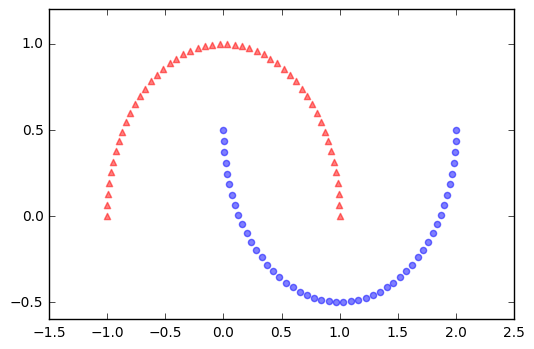

In [3]:
# 2つの半月形データを作成し、プロット
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt 
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='b', marker='o', alpha=0.5)
plt.show()

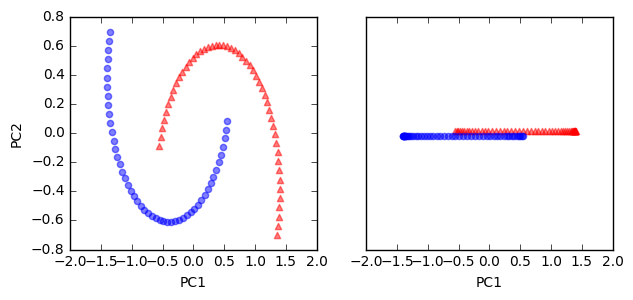

In [4]:
# 普通のPCAの場合、どうなるか見てみる
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
# グラフの数、位置、サイズを指定
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# 2特徴量でプロット
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='r', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='b', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
# 1つ目の特徴量でプロット
ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1)) + 0.02, color='r', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1)) - 0.02, color='b', marker='o', alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
plt.show()

線形分離できない

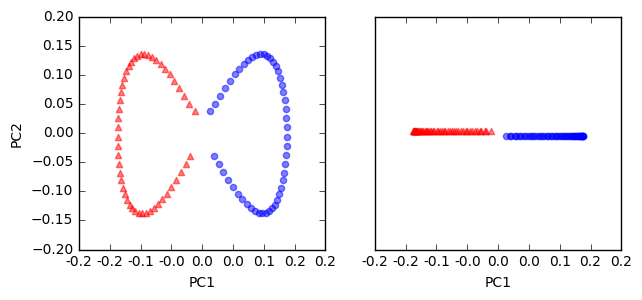

In [5]:
# カーネルPCAを試してみる
from matplotlib.ticker import FormatStrFormatter
# 作成したカーネルPCAを使う
X_kpca  = rbf_kernel_pca(X, gamma=15, n_components=2)
# グラフの数、位置、サイズを指定
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# 2特徴量でプロット
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='r', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='b', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
# 1つ目の特徴量でプロット
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1)) + 0.02, color='r', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1)) - 0.02, color='b', marker='o', alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

上記は線形分離できる

##### 例2: 同心円分離

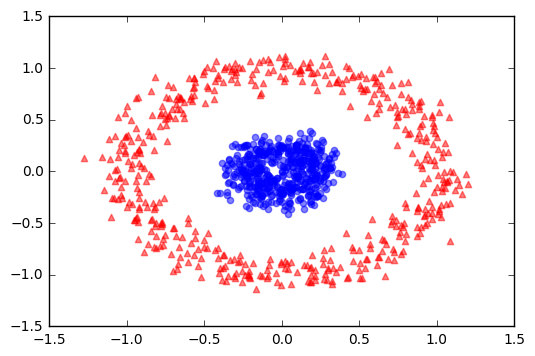

In [6]:
# 同心円データを作成しプロット
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='b', marker='o', alpha=0.5)
plt.show()

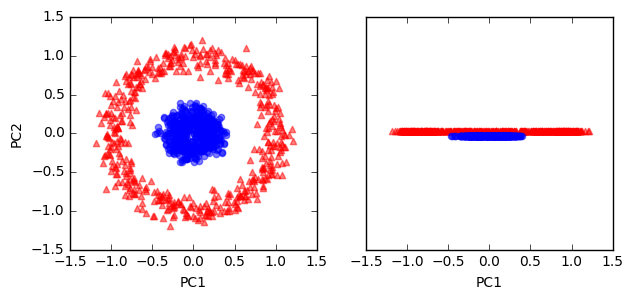

In [7]:
# 通常のPCAを試す
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
# グラフの数、位置、サイズを指定
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# 2特徴量でプロット
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='r', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='b', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
# 1つ目の特徴量でプロット
ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1)) + 0.02, color='r', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1)) - 0.02, color='b', marker='o', alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
plt.show()

線形分離できない

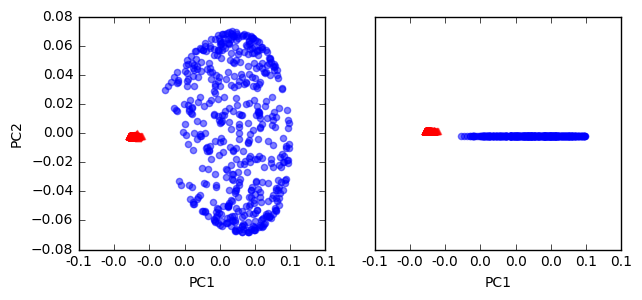

In [8]:
# カーネルPCAを試す
X_kpca  = rbf_kernel_pca(X, gamma=15, n_components=2)
# グラフの数、位置、サイズを指定
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
# 2特徴量でプロット
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='r', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='b', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
# 1つ目の特徴量でプロット
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1)) + 0.02, color='r', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1)) - 0.02, color='b', marker='o', alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

こちらは線形分離できる

#### 新しいデータ点を射影する

標準のPCAでは共分散行列から取り出したk個の固有ベクトルを変換行列とし、サンプルと掛けあわせて射影を行う<br>
カーネルPCAでは高次元への変換関数$\phi$で変換した値に、固有ベクトルを掛けて射影する<br>
$$
\phi({\bf x'})^T{\bf v}
$$

※ $\bf v$は1つの特徴量に対応する変換ベクトル

こちらもカーネルトリックを用いて、カーネル行列の計算で求めることができる

$$
\phi({\bf x'})^T{\bf v} = \sum_i{\bf a^{(i)}k({\bf x'}, {\bf x^{(i)}})^T}
$$

※ ${\bf a}$はカーネル（類似度）行列Kの固有ベクトル

In [9]:
# カーネルPCAを固有値を返すように修正する
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBFカーネルPCA
    
    パラメータ
    ----------------
    X: {Numpy ndarray}, shape = {n_samples, n_features}
    gamma: float RBFカーネルのチューニングパラメータ
    n_components: int 返される主成分の個数

    戻り値
    ----------------
    X_pc: {Numpy ndarray}, shape = {n_samples, k_features} 射影されたデータセット（k個の特徴量）
    lambdas: list 固有値
    """
    
    # データごとの平方ユークリッド距離を計算
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 各データからみた距離を作成(正方行列) -> || x_i - x_j ||^2 
    mat_sq_dists = squareform(sq_dists)
    
    # カーネル（類似度）行列を計算
    K = exp(-gamma * mat_sq_dists)
    
    # カーネル行列を中心化
    N = K.shape[0]  # サンプル数
    one_n = np.ones((N, N)) / N  # 1_nの作成
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # カーネルから固有値と固有ベクトルを取得
    # numpy.eighはソートして返してくれる
    eigvals, eigvecs = eigh(K)
    
    # 上位n_components個の固有ベクトル＝射影されたサンプルを収集
    alphas = np.column_stack((eigvecs[:, -i]) for i in range(1, n_components + 1))
    
    # 対応する固有値を収集
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]
    
    return alphas, lambdas

In [10]:
# 半月形データセットを再度作成
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1) 

In [11]:
# 26番めのデータに着目し、正しく射影できるかを見る
x_new = X[25]
x_new

array([ 1.8713187 ,  0.00928245])

In [12]:
x_proj = alphas[25]
x_proj

array([ 0.07877284])

In [13]:
# 射影する関数
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row) ** 2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas) # カーネル関数とカーネル固有ベクトルで変換したあと、固有値で正規化する必要がある

In [14]:
# 元の射影を再現する
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([ 0.07877284])

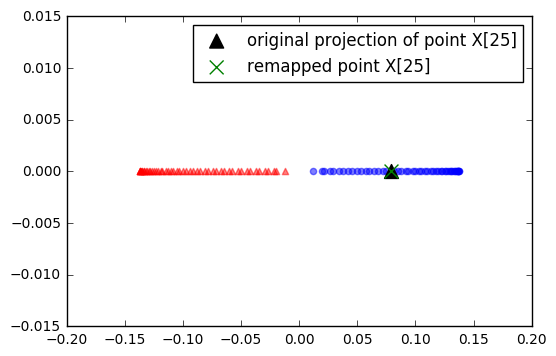

In [15]:
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='r', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='b', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='g', label='remapped point X[25]', marker='x', s=100)
plt.legend(scatterpoints=1)
plt.show()

上記から正しく写像されていることがわかる

### scikit-learnのカーネル主成分分析

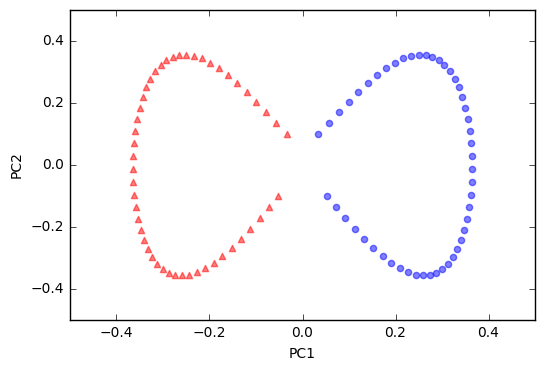

In [16]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='r', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='b', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

上記の結果は実装した結果と一致する